# First Down Analysis

## This notebook goes over results of NFL play by play data from 2009-2018. I take a deep dive into the likelihood of achieving a first down, touchdown, or scoring points. 

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
nfl_data = pd.read_csv('NFL Play by Play 2009-2018.csv')

In [3]:
nfl_data.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [4]:
# Some teams have moved over the years, so this dictionary will help map the teams together.

teams_mapping = {}
for team in nfl_data['home_team'].unique():
    if team == 'STL':
        teams_mapping[team] = 'LA'
    elif team == 'SD':
        teams_mapping[team] = 'LAC'
    elif team == 'JAC':
        teams_mapping[team] = 'JAX'
    else:
        teams_mapping[team] = team
teams_mapping

{'PIT': 'PIT',
 'CLE': 'CLE',
 'NO': 'NO',
 'TB': 'TB',
 'HOU': 'HOU',
 'IND': 'IND',
 'CIN': 'CIN',
 'CAR': 'CAR',
 'BAL': 'BAL',
 'ATL': 'ATL',
 'ARI': 'ARI',
 'SEA': 'SEA',
 'NYG': 'NYG',
 'GB': 'GB',
 'NE': 'NE',
 'OAK': 'OAK',
 'DET': 'DET',
 'WAS': 'WAS',
 'TEN': 'TEN',
 'PHI': 'PHI',
 'NYJ': 'NYJ',
 'KC': 'KC',
 'JAC': 'JAX',
 'SF': 'SF',
 'BUF': 'BUF',
 'SD': 'LAC',
 'DEN': 'DEN',
 'CHI': 'CHI',
 'DAL': 'DAL',
 'MIA': 'MIA',
 'MIN': 'MIN',
 'STL': 'LA',
 'LA': 'LA',
 'JAX': 'JAX',
 'LAC': 'LAC'}

In [5]:
for col in [col for col in nfl_data.columns if col.endswith('team')]:
    nfl_data[col] = nfl_data[col].map(teams_mapping)

In [7]:
# Making a dataframe called trimmed_df that just looks at columns that we are actually interested in

trimmed_df = nfl_data[['play_id','game_id','home_team','away_team','posteam','posteam_type'
          ,'defteam','side_of_field','yardline_100','half_seconds_remaining'
          ,'game_half','drive','qtr','down','yrdln','ydstogo','ydsnet','desc'
          ,'play_type','yards_gained'
          ,'home_timeouts_remaining','away_timeouts_remaining','timeout','timeout_team'
          ,'td_team','total_home_score','total_away_score','posteam_score','defteam_score'
          ,'first_down_rush', 'first_down_pass', 'first_down_penalty']]
trimmed_df.drop_duplicates(inplace = True)
trimmed_df['Season'] = trimmed_df.game_id.apply(lambda x: int(str(x)[:4]))
trimmed_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,half_seconds_remaining,...,timeout_team,td_team,total_home_score,total_away_score,posteam_score,defteam_score,first_down_rush,first_down_pass,first_down_penalty,Season
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,1800.0,...,NaN,NaN,0,0,NaN,NaN,0.0,0.0,0.0,2009
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,1793.0,...,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,2009
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,1756.0,...,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,2009
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,1715.0,...,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,2009
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,1707.0,...,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,2009


In [8]:
# Getting rid of certain play types that are not useful in determing outcomes of drives

trimmed_df['play_type'].fillna('NONE', inplace = True)
trimmed_df = trimmed_df[~trimmed_df['play_type'].isin(['kickoff','extra_point','NONE'])].sort_values(['game_id','play_id']).copy()
trimmed_df = trimmed_df[trimmed_df['Season'] >= 2014].copy()
trimmed_df.reset_index(inplace = True)
trimmed_df.drop('index', axis = 1, inplace = True)
trimmed_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,half_seconds_remaining,...,timeout_team,td_team,total_home_score,total_away_score,posteam_score,defteam_score,first_down_rush,first_down_pass,first_down_penalty,Season
0,58,2014090400,SEA,GB,GB,away,SEA,GB,87.0,1796.0,...,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,2014
1,79,2014090400,SEA,GB,GB,away,SEA,GB,81.0,1770.0,...,NaN,NaN,0,0,0.0,0.0,0.0,0.0,1.0,2014
2,111,2014090400,SEA,GB,GB,away,SEA,GB,76.0,1751.0,...,NaN,NaN,0,0,0.0,0.0,1.0,0.0,0.0,2014
3,132,2014090400,SEA,GB,GB,away,SEA,GB,61.0,1712.0,...,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,2014
4,153,2014090400,SEA,GB,GB,away,SEA,GB,59.0,1686.0,...,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0.0,2014


## These functions help take multiple columns from the trimmed_df dataframe and give an overall flag of whether a drive ends in a first down, touchdown, or field goal

In [9]:
def first_down(row):
    """
        We don't care how the first down happens, we just want to know if it did
    """
    if row['first_down_rush'] == 1 or row['first_down_pass'] == 1 or row['first_down_penalty'] == 1:
        return 1
    else:
        return 0
    
def offensive_touchdown(row):
    """
        We only really care about offensive touchdowns in this kind of analysis
    """
    if row['td_team'] == row['posteam']:
        return 1
    else:
        return 0
    
def field_goal(row):
    """
        Field goals will help determine the points scored function
    """
    if row['play_type'] == 'field_goal':
        return 1
    else:
        return 0
    
def points_scored(row):
    """
        Can use this to determine whether a drive ended in some sort of points
    """
    if row['Offensive Touchdown'] == 1 or row['Field Goal'] == 1:
        return 1
    else:
        return 0

In [10]:
trimmed_df['First Down'] = trimmed_df.apply(first_down, axis = 1)
trimmed_df['Offensive Touchdown'] = trimmed_df.apply(offensive_touchdown, axis = 1)
trimmed_df.drop('td_team',axis = 1, inplace = True)
trimmed_df['Field Goal'] = trimmed_df.apply(field_goal, axis = 1)
trimmed_df['Points Scored'] = trimmed_df.apply(points_scored, axis = 1)
trimmed_df.drop([col for col in trimmed_df.columns if 'first_' in col], axis = 1, inplace = True)
trimmed_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,half_seconds_remaining,...,timeout_team,total_home_score,total_away_score,posteam_score,defteam_score,Season,First Down,Offensive Touchdown,Field Goal,Points Scored
0,58,2014090400,SEA,GB,GB,away,SEA,GB,87.0,1796.0,...,NaN,0,0,0.0,0.0,2014,0,0,0,0
1,79,2014090400,SEA,GB,GB,away,SEA,GB,81.0,1770.0,...,NaN,0,0,0.0,0.0,2014,1,0,0,0
2,111,2014090400,SEA,GB,GB,away,SEA,GB,76.0,1751.0,...,NaN,0,0,0.0,0.0,2014,1,0,0,0
3,132,2014090400,SEA,GB,GB,away,SEA,GB,61.0,1712.0,...,NaN,0,0,0.0,0.0,2014,0,0,0,0
4,153,2014090400,SEA,GB,GB,away,SEA,GB,59.0,1686.0,...,NaN,0,0,0.0,0.0,2014,0,0,0,0


# Drive vs Drive Set

A drive is considered when a team starts with the ball and their end result of that time period. A Drive Set is every set of 1-4 downs in a drive. So, there can be multiple drive sets in a drive

In [11]:
first_downs = trimmed_df[trimmed_df['down'] == 1][['play_id','game_id','posteam','defteam','drive']].copy()
first_downs.reset_index(inplace = True)
first_downs.drop('index', axis = 1, inplace = True)
first_downs['Drive Set'] = first_downs.index + 1
first_downs

,play_id,game_id,posteam,defteam,drive,Drive Set
0,58,2014090400,GB,SEA,1,1
1,111,2014090400,GB,SEA,1,2
2,132,2014090400,GB,SEA,1,3
3,221,2014090400,SEA,GB,2,4
4,290,2014090400,SEA,GB,2,5
5,391,2014090400,SEA,GB,2,6
6,412,2014090400,SEA,GB,2,7
7,541,2014090400,GB,SEA,3,8
8,565,2014090400,GB,SEA,3,9
9,666,2014090400,GB,SEA,4,10


In [12]:
trimmed_df = pd.merge(trimmed_df, first_downs, how = 'left')
trimmed_df['Drive Set'] = trimmed_df['Drive Set'].ffill()
trimmed_df.head(10)

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,half_seconds_remaining,...,total_home_score,total_away_score,posteam_score,defteam_score,Season,First Down,Offensive Touchdown,Field Goal,Points Scored,Drive Set
0,58,2014090400,SEA,GB,GB,away,SEA,GB,87.0,1796.0,...,0,0,0.0,0.0,2014,0,0,0,0,1.0
1,79,2014090400,SEA,GB,GB,away,SEA,GB,81.0,1770.0,...,0,0,0.0,0.0,2014,1,0,0,0,1.0
2,111,2014090400,SEA,GB,GB,away,SEA,GB,76.0,1751.0,...,0,0,0.0,0.0,2014,1,0,0,0,2.0
3,132,2014090400,SEA,GB,GB,away,SEA,GB,61.0,1712.0,...,0,0,0.0,0.0,2014,0,0,0,0,3.0
4,153,2014090400,SEA,GB,GB,away,SEA,GB,59.0,1686.0,...,0,0,0.0,0.0,2014,0,0,0,0,3.0
5,177,2014090400,SEA,GB,GB,away,SEA,GB,61.0,1650.0,...,0,0,0.0,0.0,2014,0,0,0,0,3.0
6,196,2014090400,SEA,GB,GB,away,SEA,GB,61.0,1617.0,...,0,0,0.0,0.0,2014,0,0,0,0,3.0
7,221,2014090400,SEA,GB,SEA,home,GB,SEA,65.0,1613.0,...,0,0,0.0,0.0,2014,0,0,0,0,4.0
8,245,2014090400,SEA,GB,SEA,home,GB,SEA,61.0,1580.0,...,0,0,0.0,0.0,2014,0,0,0,0,4.0
9,266,2014090400,SEA,GB,SEA,home,GB,SEA,56.0,1544.0,...,0,0,0.0,0.0,2014,1,0,0,0,4.0


In [15]:
# The final dataframe takes in the last data that we are interested in

first_down_data = trimmed_df[['Season','game_id','posteam','defteam','drive','Drive Set','yardline_100'
                              ,'down','ydstogo','play_type','First Down','Offensive Touchdown','Field Goal','Points Scored']]
final_df = first_down_data[(~first_down_data['play_type'].isin(['no_play'])) & (pd.isnull(first_down_data['down']) == False)]
final_df.head()

,Season,game_id,posteam,defteam,drive,Drive Set,yardline_100,down,ydstogo,play_type,First Down,Offensive Touchdown,Field Goal,Points Scored
0,2014,2014090400,GB,SEA,1,1.0,87.0,1.0,10,run,0,0,0,0
2,2014,2014090400,GB,SEA,1,2.0,76.0,1.0,10,run,1,0,0,0
3,2014,2014090400,GB,SEA,1,3.0,61.0,1.0,10,run,0,0,0,0
4,2014,2014090400,GB,SEA,1,3.0,59.0,2.0,8,pass,0,0,0,0
5,2014,2014090400,GB,SEA,1,3.0,61.0,3.0,10,pass,0,0,0,0


In [16]:
# First Down Groupings
final_df[['Drive Set','First Down','Offensive Touchdown','Points Scored']].groupby(['Drive Set']).max().head()

,First Down,Offensive Touchdown,Points Scored
Drive Set,,,
1.0,0,0,0
2.0,1,0,0
3.0,0,0,0
4.0,1,0,0
5.0,0,0,0


In [20]:
# Drive Set Averages
print('Drive Set Averages')
final_df[['Drive Set','First Down','Offensive Touchdown','Points Scored']
        ].groupby(['Drive Set']).max().mean()

Drive Set Averages


First Down             0.644064
Offensive Touchdown    0.082758
Points Scored          0.150722
dtype: float64

In [21]:
# Full Drive Averages
print('Full Drive Averages')
final_df[['game_id','drive','posteam','defteam','First Down','Offensive Touchdown','Points Scored']
        ].groupby(['game_id','drive','posteam','defteam']).max().mean()

Full Drive Averages


First Down             0.659300
Offensive Touchdown    0.205826
Points Scored          0.374830
dtype: float64

In [22]:
team_first_downs = final_df[['Season','posteam','Drive Set','First Down']].groupby(['Season','posteam','Drive Set'], as_index = False).max()

In [24]:
# Break up teams into the divisions they belong to

def set_divisions(row):
    team = row['Team']
    if team in ['BUF','MIA','NE','NYJ']:
        return 'AFC East'
    elif team in ['DEN','KC','LAC','OAK']:
        return 'AFC West'
    elif team in ['BAL','CIN','CLE','PIT']:
        return 'AFC North'
    elif team in ['HOU','IND','JAX','TEN']:
        return 'AFC South'
    elif team in ['DAL','NYG','PHI','WAS']:
        return 'NFC East'
    elif team in ['ARI','LA','SF','SEA']:
        return 'NFC West'
    elif team in ['CHI','DET','GB','MIN']:
        return 'NFC North'
    else:
        return 'NFC South'
    
conferences = pd.DataFrame(list(team_first_downs.posteam.unique()), columns = ['Team'])
conferences['Division'] = conferences.apply(set_divisions, axis = 1)
conferences.head()

,Team,Division
0,ARI,NFC West
1,ATL,NFC South
2,BAL,AFC North
3,BUF,AFC East
4,CAR,NFC South


# How do teams stack up against each other in their division in first down conversion rates?

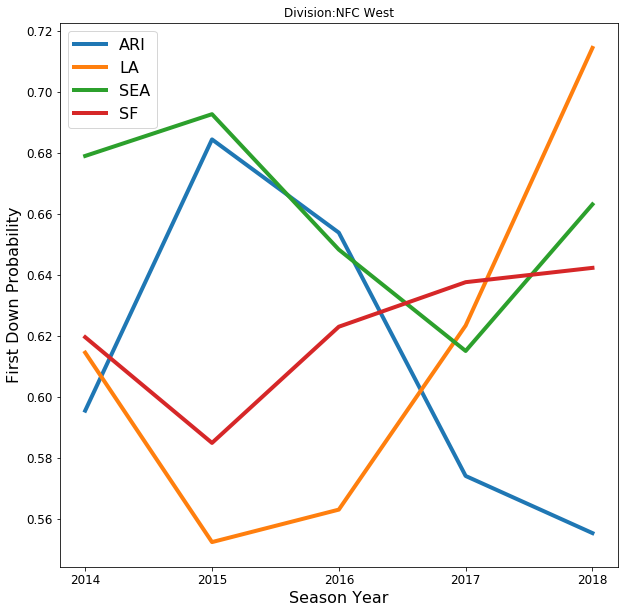

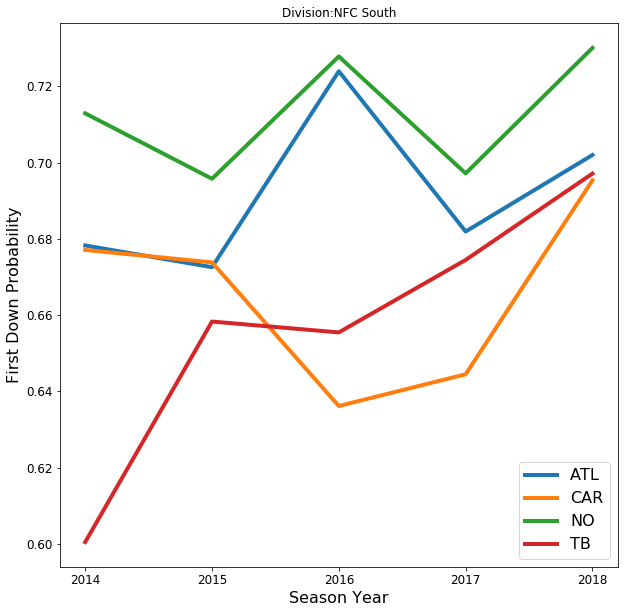

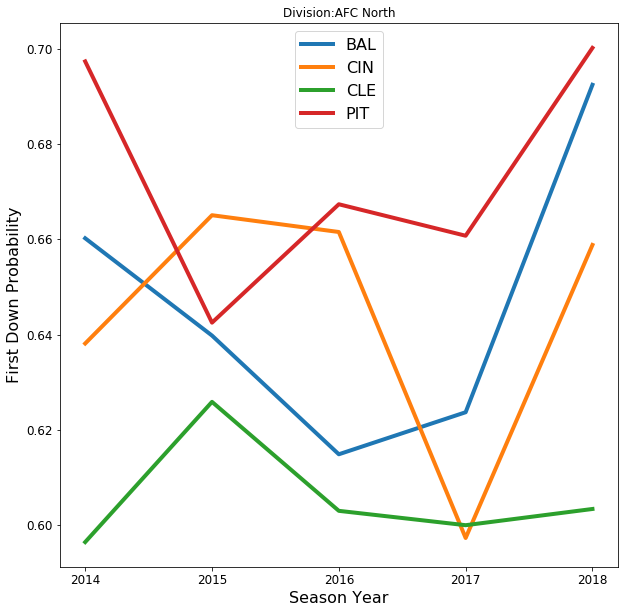

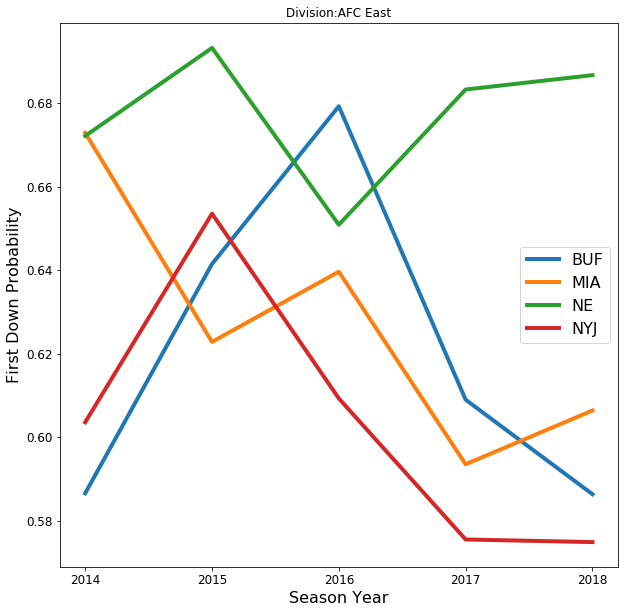

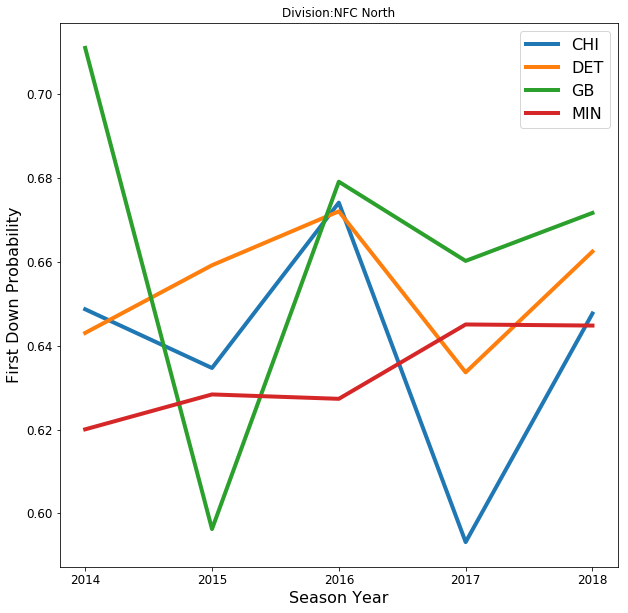

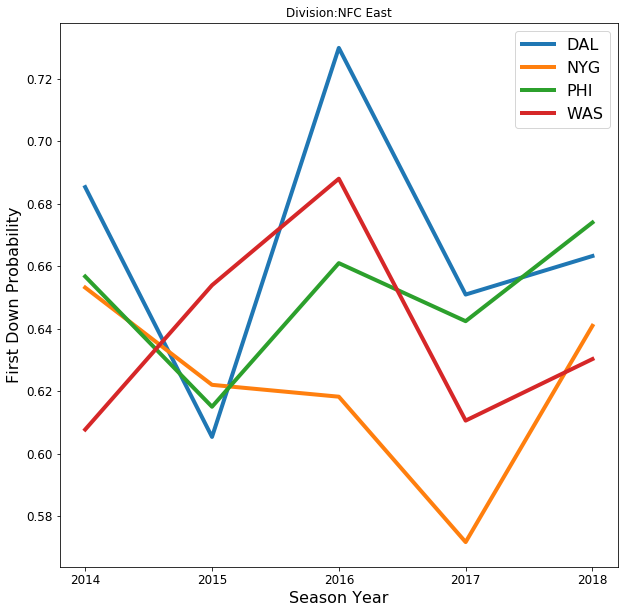

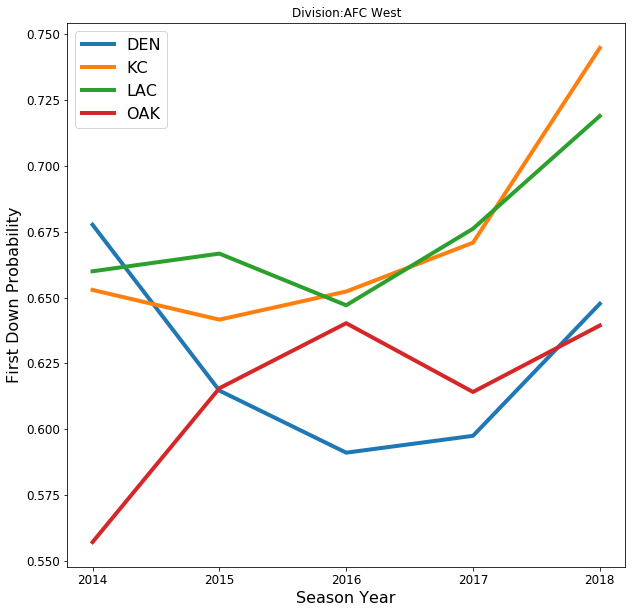

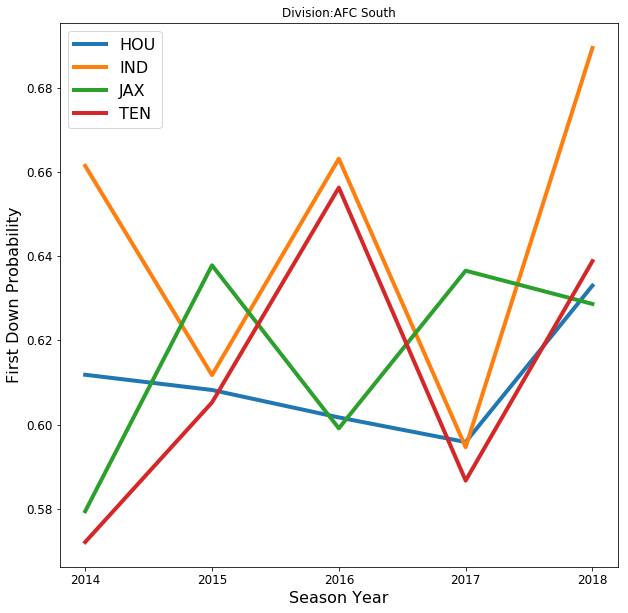

In [25]:
for division in conferences.Division.unique():

    plt.figure(figsize = (10,10))
    
    teams_of_interest = conferences[conferences['Division'] == division]['Team'].unique()

    team_first_downs = final_df[['Season','posteam','Drive Set','First Down']].groupby(['Season','posteam','Drive Set'], as_index = False).max()
    for team in teams_of_interest:
        df = team_first_downs[team_first_downs['posteam'] == team][['Season','First Down']]
        df_group = df.groupby(['Season']).mean()
        df_group['First Down'].plot(label = team, linewidth = 4)

    plt.legend(fontsize = 16)
    plt.ylabel('First Down Probability', fontsize = 16)
    plt.xlabel('Season Year', fontsize = 16)
    plt.xticks([i for i in range(2014, 2019)], fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title('Division:{}'.format(division))

# League wide comparisions of first down success

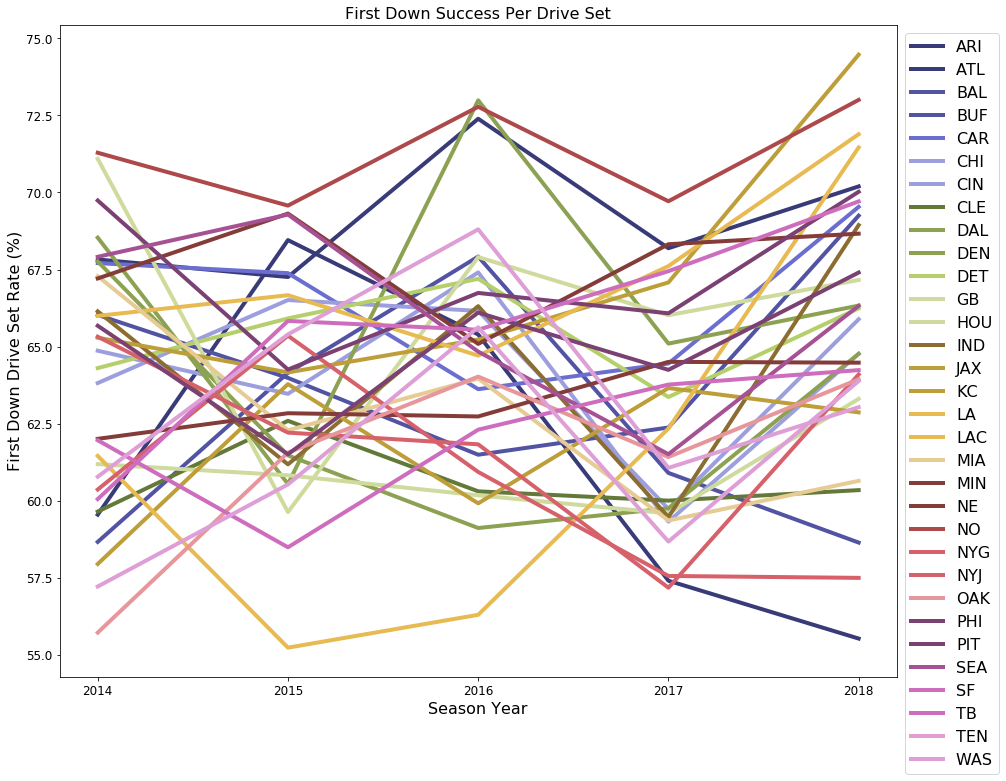

In [27]:
plt.figure(figsize = (15,12))
colormap = plt.cm.tab20b
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 1, len(conferences))])

for team in conferences['Team']:
    df = team_first_downs[team_first_downs['posteam'] == team][['Season','First Down']]
    df['Season'] = df.Season.apply(lambda x: int(x))
    df_group = df.groupby(['Season']).mean() * 100
    df_group['First Down'].plot(label = team, linewidth = 4)

plt.legend(fontsize = 16,bbox_to_anchor=(1, 1))
plt.ylabel('First Down Drive Set Rate (%)', fontsize = 16)
plt.xlabel('Season Year', fontsize = 16)
plt.xticks([i for i in range(2014, 2019)], fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('First Down Success Per Drive Set', fontsize = 16);

# Drive Set Start Analysis

In [28]:
def interval_values(val):
    """
        This function will classify what range the drive / drive set started
    """
    val = val['yardline_100']
    if val > 0 and val <= 10:
        return "1-10"
    elif val > 10 and val <= 20:
        return "11-20"
    elif val > 20 and val <= 30:
        return "21-30"
    elif val > 30 and val <= 40:
        return "31-40"
    elif val > 40 and val <= 50:
        return "41-50"
    elif val > 50 and val <= 60:
        return "51-60"
    elif val > 60 and val <= 70:
        return "61-70"
    elif val > 70 and val <= 80:
        return "71-80"
    elif val > 80 and val <= 90:
        return "81-90"
    elif val > 90 and val <= 100:
        return "91-100"

# Likelihood of outcome depending on where your drive set starts
yardline_drive_set_results = final_df[['Drive Set','yardline_100','First Down','Offensive Touchdown','Points Scored']
                           ].groupby(['Drive Set']).max()
yardline_drive_set_results['Field Location'] = yardline_drive_set_results.apply(interval_values, axis = 1)
yardline_drive_set_results.head()

,yardline_100,First Down,Offensive Touchdown,Points Scored,Field Location
Drive Set,,,,,
1.0,87.0,0,0,0,81-90
2.0,76.0,1,0,0,71-80
3.0,61.0,0,0,0,61-70
4.0,65.0,1,0,0,61-70
5.0,52.0,0,0,0,51-60


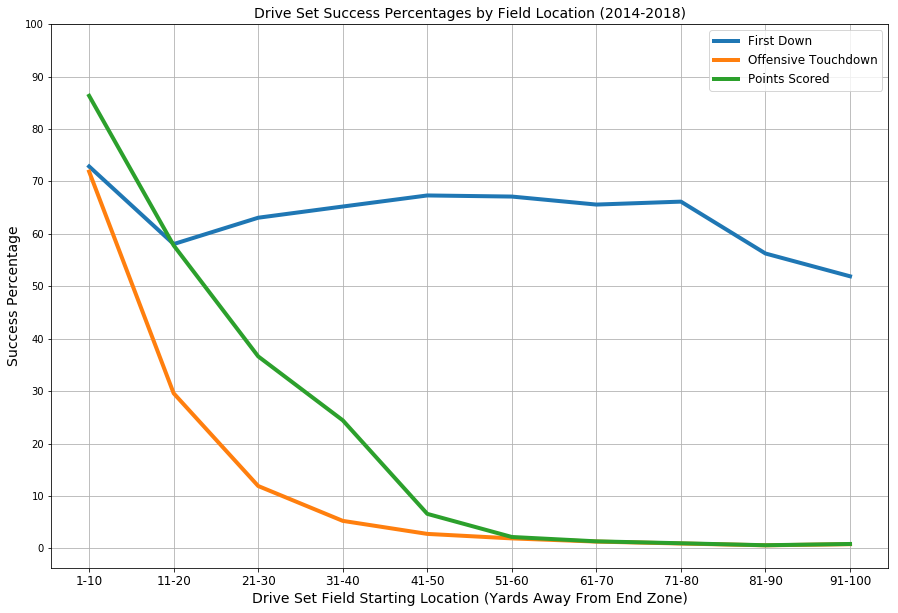

In [29]:
field_interval_results = yardline_drive_set_results[['Field Location','First Down','Offensive Touchdown','Points Scored']].groupby(
    ['Field Location']).mean()
(field_interval_results * 100).plot(figsize = (15,10), linewidth = 4)
plt.legend(fontsize = 12)
plt.xticks(np.arange(10), tuple(field_interval_results.index), fontsize = 12)
plt.yticks(np.arange(0,1.1, .1)*100)
plt.ylabel('Success Percentage', fontsize = 14)
plt.xlabel('Drive Set Field Starting Location (Yards Away From End Zone)',fontsize = 14)
plt.title('Drive Set Success Percentages by Field Location (2014-2018)', fontsize = 14)
plt.grid();

In [30]:
# Likelihood of outcome depending on where your drive set starts
yardline_drive_results = final_df[['game_id','drive','yardline_100','First Down','Offensive Touchdown','Points Scored']
                           ].groupby(['game_id','drive']).max()
yardline_drive_results['Field Location'] = yardline_drive_results.apply(interval_values, axis = 1)
yardline_drive_results.head()

yardline_100  First Down  Offensive Touchdown  \
game_id    drive                                                  
2014090400 1              87.0           1                    0   
           2              65.0           1                    0   
           3              80.0           1                    0   
           4              34.0           1                    1   
           5              90.0           1                    1   

                  Points Scored Field Location  
game_id    drive                                
2014090400 1                  0          81-90  
           2                  1          61-70  
           3                  0          71-80  
           4                  1          31-40  
           5                  1          81-90

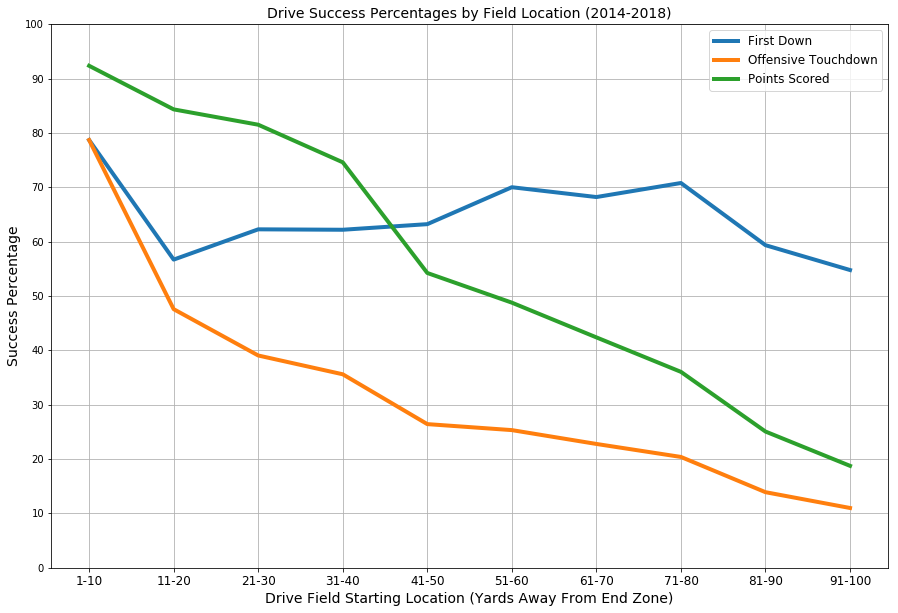

In [31]:
field_interval_results = yardline_drive_results[['Field Location','First Down','Offensive Touchdown','Points Scored']].groupby(
    ['Field Location']).mean()
(field_interval_results * 100).plot(figsize = (15,10), linewidth = 4)
plt.legend(fontsize = 12)
plt.xticks(np.arange(10), tuple(field_interval_results.index), fontsize = 12)
plt.yticks(np.arange(0,1.1, .1)*100)
plt.ylabel('Success Percentage', fontsize = 14)
plt.xlabel('Drive Field Starting Location (Yards Away From End Zone)',fontsize = 14)
plt.title('Drive Success Percentages by Field Location (2014-2018)', fontsize = 14)
plt.grid();

# First Down Success On Each Down

In [32]:
down_info = final_df[['down', 'Drive Set', 'yardline_100', 'ydstogo','First Down']]
down_info = pd.merge(down_info, final_df[['Drive Set','First Down']].groupby('Drive Set', as_index = False).max().rename(columns = {'First Down':'Drive Set First Down'}))
down_info.head()

,down,Drive Set,yardline_100,ydstogo,First Down,Drive Set First Down
0,1.0,1.0,87.0,10,0,0
1,1.0,2.0,76.0,10,1,1
2,1.0,3.0,61.0,10,0,0
3,2.0,3.0,59.0,8,0,0
4,3.0,3.0,61.0,10,0,0


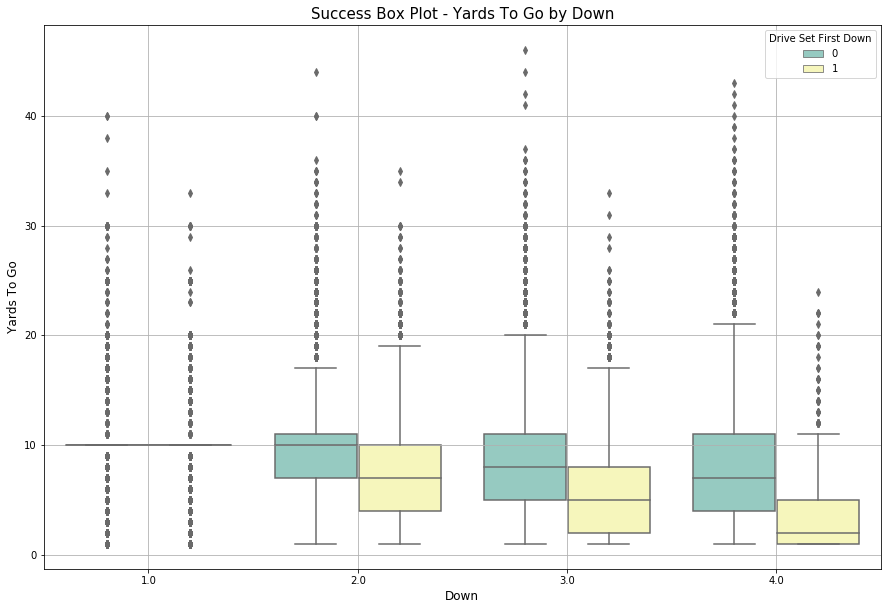

In [33]:
plt.figure(figsize = (15,10))
sns.boxplot(x="down", y="ydstogo", hue="Drive Set First Down",
                data=down_info, palette="Set3")
plt.ylabel('Yards To Go', fontsize = 12)
plt.xlabel('Down', fontsize = 12)
plt.title('Success Box Plot - Yards To Go by Down', fontsize = 15)
plt.grid();

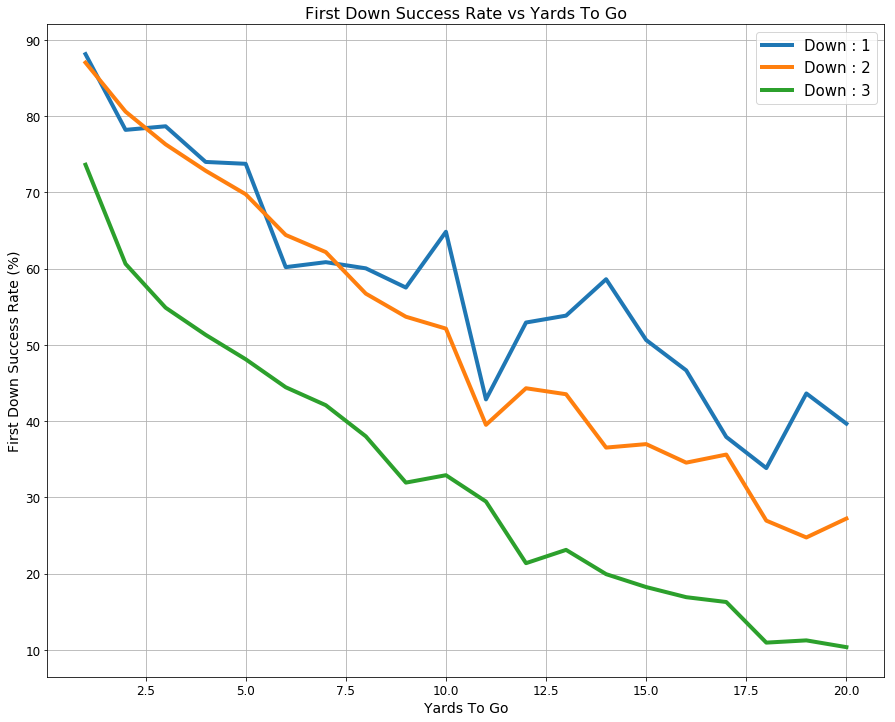

In [34]:
plt.figure(figsize = (15,12))
down_pcts = down_info[['down','ydstogo','Drive Set First Down']].groupby(['down','ydstogo'], as_index = False).mean()
for down in range(1,4):
    down_df = down_pcts[(down_pcts['down'] == down) & (down_pcts['ydstogo'] <=20)][['ydstogo','Drive Set First Down']]
    down_df.set_index('ydstogo', inplace = True)
    (down_df['Drive Set First Down'] * 100).plot(label = 'Down : '+ str(down), linewidth = 4)
plt.legend(fontsize = 15)
plt.ylabel('First Down Success Rate (%)', fontsize = 14)
plt.xlabel('Yards To Go', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('First Down Success Rate vs Yards To Go', fontsize = 16)
plt.grid()

In [35]:
down_vs_yards_success = down_pcts[down_pcts['ydstogo'] <= 20].pivot(index = 'ydstogo',columns = 'down', values = 'Drive Set First Down')
down_vs_yards_success.index.rename('Yards To Go', inplace='True')
down_vs_yards_success

down,1.0,2.0,3.0,4.0
Yards To Go,,,,
1,0.881481,0.870390,0.736419,0.301897
2,0.782123,0.806087,0.606363,0.105941
3,0.786842,0.763168,0.548881,0.070175
4,0.740053,0.728514,0.513258,0.052553
5,0.737613,0.697669,0.481225,0.051058
6,0.602067,0.644231,0.444487,0.041726
7,0.608579,0.621796,0.420945,0.034119
8,0.600490,0.567301,0.380096,0.019856
9,0.575281,0.537008,0.319409,0.014706


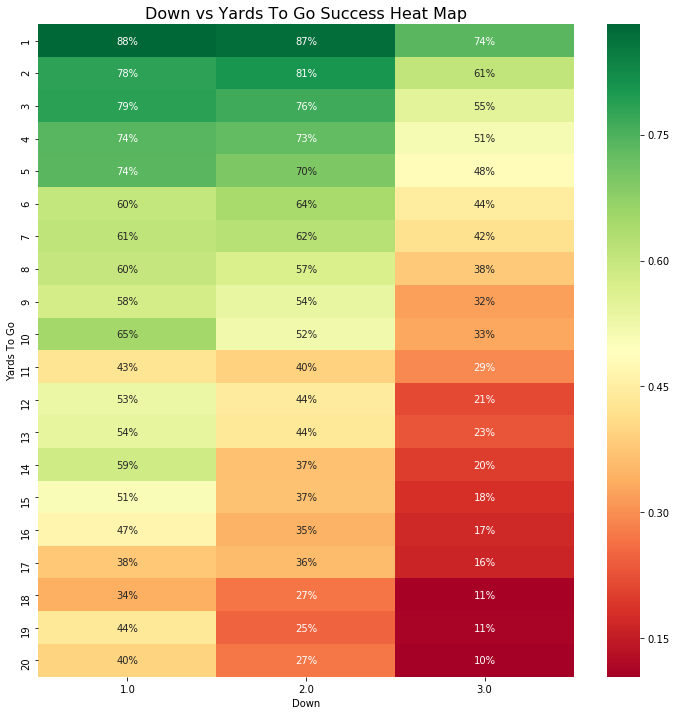

In [36]:
plt.figure(figsize = (12,12))
sns.heatmap(down_vs_yards_success[[1,2,3]], annot=True, cmap="RdYlGn", fmt=".0%")
plt.xlabel('Down')
plt.title('Down vs Yards To Go Success Heat Map', fontsize =16);